<a href="https://colab.research.google.com/github/Fredherve/Asset-Management/blob/main/gestion_active.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Etapes de construction d'un portefeuille multi-asset :

1) extraire rendement historique actifs (attention aux devises) \\
2) calculer mu et la matrice de cov \\
3) optimiser et obtenir w_p \\
4) déduire le portefeuille de marché \\
5) ajouter les contraintes 0=< wi=< 1

on prend des actifs diversifiés afin de pouvoir inverser la matrice de covariance par la suite

exemples à tester par la suite :
1. Actifs internationaux ou émergents :
VWO (Vanguard FTSE Emerging Markets ETF) : Exposition aux marchés émergents. Si tu veux avoir plus d'exposition aux économies en croissance (sans être limité aux marchés développés).
EFA (iShares MSCI EAFE ETF) : Exposition aux marchés développés hors des États-Unis (Europe, Australie, etc.).
2. Secteurs spécifiques :
XLY (Consumer Discretionary Select Sector SPDR Fund) : Exposition aux entreprises du secteur de la consommation discrétionnaire (par exemple, Amazon, Tesla, etc.), qui peuvent performer indépendamment des autres secteurs.
XLC (Communication Services Select Sector SPDR Fund) : Exposition aux entreprises de communication (par exemple, Facebook, Google, Netflix), offrant une diversification sectorielle.
XLF (Financial Select Sector SPDR Fund) : Exposition au secteur financier, qui peut être corrélé différemment avec d'autres secteurs en fonction des taux d'intérêt et de la conjoncture économique.
3. Immobilier et infrastructure :
VNQ (Vanguard Real Estate ETF) : Exposition au marché immobilier via des sociétés immobilières cotées en bourse (REITs), qui peuvent offrir des rendements intéressants en périodes de faible taux d'intérêt.
IGF (iShares Global Infrastructure ETF) : Exposition aux sociétés d'infrastructure mondiales (routes, électricité, etc.).
4. Marchés de matières premières :
USO (United States Oil Fund) : Exposition au pétrole brut. Bien que cela puisse être volatil, cela peut ajouter une autre dimension à ton portefeuille.
PALL (Palladium Fund) : Exposition au palladium, un métal précieux ayant des corrélations et des dynamiques de marché différentes par rapport à l'or.
5. Cryptomonnaies et actifs alternatifs :
GBTC (Grayscale Bitcoin Trust) : Exposition à Bitcoin. Bien que volatile, le Bitcoin est souvent vu comme un "or numérique" et peut offrir une diversification supplémentaire.
ETH (Ethereum, ou un autre ETF ou trust lié à Ethereum) : Exposition à la blockchain et à la cryptomonnaie, qui peut se comporter de manière différente des autres classes d'actifs.
6. Actifs à faible corrélation :
TIP (iShares TIPS Bond ETF) : Obligations protégées contre l'inflation (TIPS), qui peuvent offrir une protection en période de hausse des prix.
SHY (iShares 1-3 Year Treasury Bond ETF) : Obligations à court terme, qui sont moins sensibles aux variations des taux d'intérêt et aux fluctuations économiques globales.

essayer le CAC 40

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Liste des tickers des actifs financiers
tickers = ['MSFT', 'NVDA', 'SPY', 'TLT', 'GLD', 'UUP', 'DBC','VWO','GBTC', 'USO', 'PALL']

# Période des données (5 ans d'historique)
start_date = '2019-01-01'
end_date = '2024-01-01'

# Téléchargement des données de prix
prices = yf.download(tickers, start=start_date, end=end_date)['Close']
print(prices)

[*********************100%***********************]  11 of 11 completed

Ticker            DBC       GBTC         GLD        MSFT       NVDA  \
Date                                                                  
2019-01-02  12.862573   4.620000  121.330002   95.310539   3.378090   
2019-01-03  12.968801   4.520000  122.430000   91.804253   3.173995   
2019-01-04  13.145852   4.530000  121.440002   96.074005   3.377346   
2019-01-07  13.243227   4.860000  121.860001   96.196533   3.556144   
2019-01-08  13.376014   4.960000  121.529999   96.894035   3.467613   
...               ...        ...         ...         ...        ...   
2023-12-22  21.103357  36.910000  190.270004  371.799713  48.816162   
2023-12-26  21.312208  35.650002  191.720001  371.879120  49.265030   
2023-12-27  21.217276  36.250000  192.589996  371.293518  49.402992   
2023-12-28  21.036905  34.810001  191.470001  372.494507  49.507965   
2023-12-29  20.922987  34.619999  191.169998  373.248871  49.507965   

Ticker            PALL         SPY         TLT        USO        UUP  \
Date

Calcul de mu et la matrice de cov \\
plutot calculer le rendement moyen sur les 5 ans d'historique puis l'annualiser (si rendement de 10% sur les 5 dernières années, on l'annualise et on fait puissance 1/5)

In [2]:
# Calcul des rendements totaux sur les 5 ans pour chaque actif
total_returns = (prices.iloc[-1] / prices.iloc[0]) - 1

# Annualisation des rendements totaux
annualized_returns = (1 + total_returns) ** (1/5) - 1

# Conversion en pourcentage
total_returns_percentage = total_returns * 100
annualized_returns_percentage = annualized_returns * 100

# Affichage des résultats en pourcentage
print("Rendements totaux sur 5 ans (%):")
print(total_returns_percentage)
print("\nRendements annualisés (%):")
print(annualized_returns_percentage)


Rendements totaux sur 5 ans (%):
Ticker
DBC       62.665646
GBTC     649.350645
GLD       57.562017
MSFT     291.613429
NVDA    1365.560908
PALL     -15.779391
SPY      106.156859
TLT       -9.573280
USO      -15.418783
UUP       15.661014
VWO       25.637147
dtype: float64

Rendements annualisés (%):
Ticker
DBC     10.219686
GBTC    49.601868
GLD      9.519211
MSFT    31.392784
NVDA    71.080604
PALL    -3.376297
SPY     15.568522
TLT     -1.992490
USO     -3.293696
UUP      2.952619
VWO      4.670335
dtype: float64


on fait maintenant le calcul de la variance :

je peux prendre la fin de mois de mes actifs et calculer la volatilité dessus, puis j'annualise avec sigma annulalisé = sigma mensuel * sqrt(12)

car si on fait la variance sur les jours, on aura tendance à la sur-estimer car on va multiplier par sqrt(252)

In [4]:
# Rééchantillonnage pour obtenir les prix de fin de mois
monthly_prices = prices.resample('ME').last()  # 'ME' pour Month-End

# Calcul des rendements mensuels
monthly_returns = monthly_prices.pct_change()

# Calcul de la matrice de variance-covariance des rendements mensuels
cov_matrix_monthly = monthly_returns.cov()

# Annualisation de la matrice de variance-covariance
cov_matrix_annualized = cov_matrix_monthly * 12

# Conversion en pourcentage
cov_matrix_annualized_percentage = cov_matrix_annualized * 100

# Affichage de la matrice de variance-covariance annualisée
print("\n Matrice de variance-covariance annualisée des rendements (en pourcentage) :\n")
print(cov_matrix_annualized_percentage)



 Matrice de variance-covariance annualisée des rendements (en pourcentage) 
:
Ticker       DBC       GBTC       GLD      MSFT       NVDA       PALL  \
Ticker                                                                  
DBC     3.608899   1.939927  0.096490  0.606718   0.850600   1.300544   
GBTC    1.939927  71.449076  2.805657  7.774158   6.668589   1.077618   
GLD     0.096490   2.805657  2.133349  1.021457   1.171008   0.592225   
MSFT    0.606718   7.774158  1.021457  4.920268   7.126346   0.305928   
NVDA    0.850600   6.668589  1.171008  7.126346  24.754514  -1.395782   
PALL    1.300544   1.077618  0.592225  0.305928  -1.395782  10.749025   
SPY     1.628509   6.966438  0.677509  3.035725   5.695665   0.455295   
TLT    -1.094917   2.783924  0.963509  1.295807   2.860511   0.318714   
USO     7.552767   0.573977 -0.837953  0.438179   2.007562   3.612804   
UUP    -0.443417  -1.518178 -0.591170 -0.614359  -1.154385  -0.333146   
VWO     1.821394   4.040255  0.901406  1.9682

on peut en déduire la matrice de corrélation, utile pour savoir si la matrice va être inversible ou pas (condition essentielle)

Ticker       DBC      GBTC       GLD      MSFT      NVDA      PALL       SPY  \
Ticker                                                                         
DBC     1.000000  0.120809  0.034775  0.143981  0.089993  0.208811  0.465689   
GBTC    0.120809  1.000000  0.227251  0.414630  0.158565  0.038885  0.447719   
GLD     0.034775  0.227251  1.000000  0.315279  0.161139  0.123672  0.251987   
MSFT    0.143981  0.414630  0.315279  1.000000  0.645722  0.042067  0.743466   
NVDA    0.089993  0.158565  0.161139  0.645722  1.000000 -0.085567  0.621886   
PALL    0.208811  0.038885  0.123672  0.042067 -0.085567  1.000000  0.075440   
SPY     0.465689  0.447719  0.251987  0.743466  0.621886  0.075440  1.000000   
TLT    -0.350910  0.200521  0.401630  0.355670  0.350040  0.059186  0.208390   
USO     0.852847  0.014566 -0.123067  0.042375  0.086555  0.236381  0.311169   
UUP    -0.349135 -0.268654 -0.605410 -0.414282 -0.347050 -0.151991 -0.551098   
VWO     0.531994  0.265217  0.342436  0.

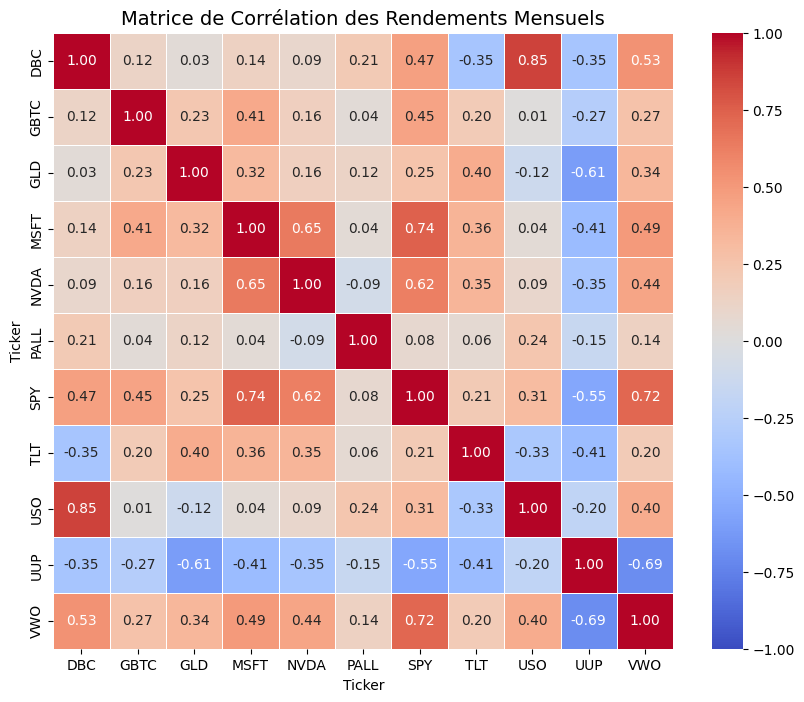

In [5]:
import seaborn as sns

corr_matrix_monthly = monthly_returns.corr()
print(corr_matrix_monthly)
# Affichage de la matrice de corrélation avec couleurs
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_monthly, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Matrice de Corrélation des Rendements Mensuels', fontsize=14)
plt.show()

In [6]:
import numpy as np

# Vérification de l'inversibilité de la matrice de corrélation
det_corr_matrix = np.linalg.det(corr_matrix_monthly)

if det_corr_matrix != 0:
    print("La matrice de corrélation est inversible.")
else:
    print("La matrice de corrélation n'est pas inversible.")

La matrice de corrélation est inversible.


3) on peut maintenant optimiser l'algorithme et obtenir w(p)

In [7]:
import numpy as np
import cvxpy as cp
import pandas as pd

# Données (les matrices et vecteurs que nous avons calculées dans les étapes précédentes)
# Rendements espérés annualisés (vecteur mu)
mu = annualized_returns.values  # Rendements espérés

# Matrice de variance-covariance annualisée (Sigma)
Sigma = cov_matrix_annualized.values

# Nombre d'actifs
n_assets = len(mu)

# Variables de décision : poids des actifs dans le portefeuille
weights = cp.Variable(n_assets)

# Paramètre : rendement cible (à ajuster selon le besoin)
mu_target = 0.15 # Exemple : rendement cible de 5%

# Fonction objectif : minimisation du risque (variance du portefeuille)
risk = cp.quad_form(weights, Sigma)

# Contraintes
constraints = [
    weights @ mu >= mu_target,  # Rendement cible
    cp.sum(weights) == 1     # Somme des poids = 1
]

# Problème d'optimisation
problem = cp.Problem(cp.Minimize(risk), constraints)

# Résolution
problem.solve()

# Résultats
print("Statut de la résolution :", problem.status)
print("Risque minimal (variance) :", problem.value)
print("Poids optimaux des actifs :", weights.value)

# Affichage des poids associés à chaque actif
optimal_weights = pd.Series(weights.value, index=tickers)
print("\nPoids optimaux par actif :")
print(optimal_weights)

Statut de la résolution : optimal
Risque minimal (variance) : 0.0030082085029726714
Poids optimaux des actifs : [ 0.33919488  0.00992375  0.16410574  0.11748798  0.08653677  0.00781114
 -0.1502561  -0.04704878 -0.09218619  0.59849237 -0.03406156]

Poids optimaux par actif :
MSFT    0.339195
NVDA    0.009924
SPY     0.164106
TLT     0.117488
GLD     0.086537
UUP     0.007811
DBC    -0.150256
VWO    -0.047049
GBTC   -0.092186
USO     0.598492
PALL   -0.034062
dtype: float64


SML : on peut utiliser la formule fermée pour la calculer; normalement, on la calcule sans al contrainte >=0

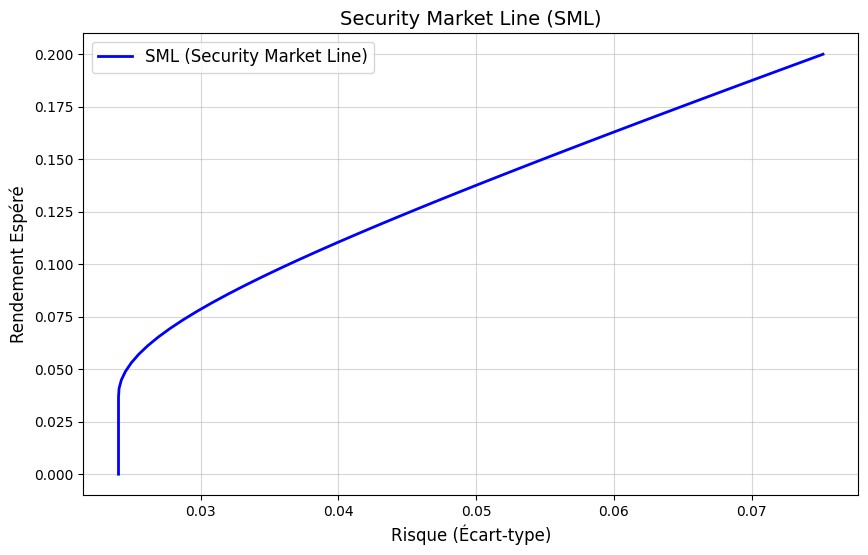

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Définir une plage de rendements cibles pour construire la SML
mu_targets = np.linspace(0, 0.2, 50)
risks = []

for target in mu_targets:
    # Créer un problème d'optimisation pour chaque rendement cible
    weights = cp.Variable(n_assets)
    risk = cp.quad_form(weights, Sigma)
    constraints = [
        weights @ mu >= target,  # Rendement cible variable
        cp.sum(weights) == 1
    ]
    problem = cp.Problem(cp.Minimize(risk), constraints)
    problem.solve()
    # Stocker le risque minimal (écart-type) pour ce rendement cible
    risks.append(np.sqrt(problem.value))

# Tracer la SML
plt.figure(figsize=(10, 6))
plt.plot(risks, mu_targets, label='SML (Security Market Line)', color='blue', lw=2)
plt.xlabel('Risque (Écart-type)', fontsize=12)
plt.ylabel('Rendement Espéré', fontsize=12)
plt.title('Security Market Line (SML)', fontsize=14)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()

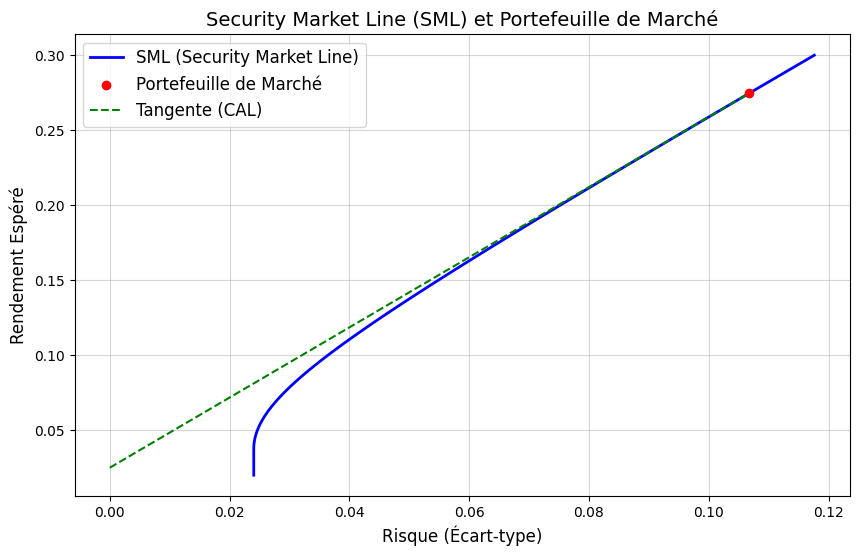

Poids du portefeuille de marché : [ 0.60816157  0.02367105  0.22305144  0.26140332  0.18575479  0.01589504
 -0.34677709 -0.21135313 -0.18075146  0.58086177 -0.15991729]
Rendement du portefeuille de marché : 0.27454545454545454
Risque du portefeuille de marché : 0.10670203108000592


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Définir une plage de rendements cibles pour construire la SML
mu_targets = np.linspace(0.02, 0.3, 100)
risks = []

# Définir le taux sans risque
risk_free_rate = 0.025

def find_tangency_portfolio():
    max_slope = -np.inf
    tangency_weights = None
    tangency_return = None
    tangency_risk = None

    for target in mu_targets:
        # Créer un problème d'optimisation pour chaque rendement cible
        weights = cp.Variable(n_assets)
        risk = cp.quad_form(weights, Sigma)
        constraints = [
            weights @ mu >= target,  # Rendement cible variable
            cp.sum(weights) == 1
        ]
        problem = cp.Problem(cp.Minimize(risk), constraints)
        problem.solve()

        # Stocker le risque minimal (écart-type) pour ce rendement cible
        portfolio_risk = np.sqrt(problem.value)
        risks.append(portfolio_risk)

        # Calculer la pente de la ligne passant par le taux sans risque
        slope = (target - risk_free_rate) / portfolio_risk if portfolio_risk > 0 else -np.inf

        # Trouver la pente maximale (tangente)
        if slope > max_slope:
            max_slope = slope
            tangency_weights = weights.value
            tangency_return = target
            tangency_risk = portfolio_risk

    return tangency_weights, tangency_return, tangency_risk

# Trouver le portefeuille de tangence
tangency_weights, tangency_return, tangency_risk = find_tangency_portfolio()

# Tracer la SML et la tangente
plt.figure(figsize=(10, 6))
plt.plot(risks, mu_targets, label='SML (Security Market Line)', color='blue', lw=2)
plt.scatter([tangency_risk], [tangency_return], color='red', label='Portefeuille de Marché', zorder=5)
plt.plot([0, tangency_risk], [risk_free_rate, tangency_return], label='Tangente (CAL)', color='green', linestyle='--')
plt.xlabel('Risque (Écart-type)', fontsize=12)
plt.ylabel('Rendement Espéré', fontsize=12)
plt.title('Security Market Line (SML) et Portefeuille de Marché', fontsize=14)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()

# Résultats
print("Poids du portefeuille de marché :", tangency_weights)
print("Rendement du portefeuille de marché :", tangency_return)
print("Risque du portefeuille de marché :", tangency_risk)


Question 5 : ajouter les contraintes qui interdisent la vente à découvert

In [10]:
mu_target = 0.15 # Exemple : rendement cible de 5%

# Fonction objectif : minimisation du risque (variance du portefeuille)
risk = cp.quad_form(weights, Sigma)

# Contraintes
constraints = [
    weights @ mu >= mu_target,  # Rendement cible
    cp.sum(weights) == 1,     # Somme des poids = 1
    weights >= 0,  # Interdiction de vendre à découvert
    weights <= 1  # Interdiction de vendre à découvert
]

# Problème d'optimisation
problem = cp.Problem(cp.Minimize(risk), constraints)

# Résolution
problem.solve()

# Résultats
print("Statut de la résolution :", problem.status)
print("Risque minimal (variance) :", problem.value)
print("Poids optimaux des actifs :", weights.value)

# Affichage des poids associés à chaque actif
optimal_weights = pd.Series(weights.value, index=tickers)
print("\nPoids optimaux par actif :")
print(optimal_weights)

Statut de la résolution : optimal
Risque minimal (variance) : 0.00465695505457605
Poids optimaux des actifs : [ 8.71413840e-02  1.08899952e-02  1.32612879e-01  1.09475387e-01
  1.01599891e-01  3.66039225e-23  2.76684398e-23 -5.22645275e-23
  1.27784988e-22  5.58280463e-01  7.90318373e-23]

Poids optimaux par actif :
MSFT    8.714138e-02
NVDA    1.089000e-02
SPY     1.326129e-01
TLT     1.094754e-01
GLD     1.015999e-01
UUP     3.660392e-23
DBC     2.766844e-23
VWO    -5.226453e-23
GBTC    1.277850e-22
USO     5.582805e-01
PALL    7.903184e-23
dtype: float64


[*********************100%***********************]  1 of 1 completed


Aperçu des taux à 3 mois (en %):
Ticker       ^IRX
Date             
2019-01-02  2.365
2019-01-03  2.355
2019-01-04  2.358
2019-01-07  2.353
2019-01-08  2.400


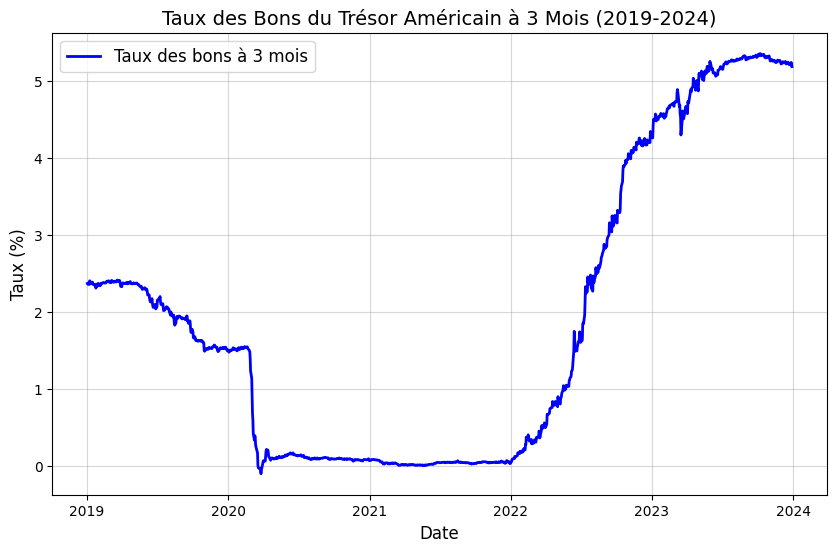

Moyenne des taux à 3 mois (en %) sur la période : Ticker
^IRX    1.884417
dtype: float64%


In [11]:
# Symbole pour les taux des bons du Trésor américain à 3 mois
risk_free_ticker = "^IRX"  # Rendement 3 mois

# Période des données
start_date = "2019-01-01"
end_date = "2024-01-01"

# Télécharger les données historiques des rendements
data = yf.download(risk_free_ticker, start=start_date, end=end_date)['Close']

# Affichage des 5 premières lignes
print("Aperçu des taux à 3 mois (en %):")
print(data.head())

# Tracer les taux à 3 mois au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label="Taux des bons à 3 mois", color='blue', lw=2)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Taux (%)", fontsize=12)
plt.title("Taux des Bons du Trésor Américain à 3 Mois (2019-2024)", fontsize=14)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()

average_rate = data.mean()
print(f"Moyenne des taux à 3 mois (en %) sur la période : {average_rate}%")

# Classe

[*********************100%***********************]  11 of 11 completed
<ipython-input-12-5a013cabdb1d>:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = self.prices.resample('M').last()


Ticker            DBC       GBTC         GLD        MSFT       NVDA  \
Date                                                                  
2019-01-02  12.862573   4.620000  121.330002   95.310539   3.378090   
2019-01-03  12.968801   4.520000  122.430000   91.804253   3.173995   
2019-01-04  13.145852   4.530000  121.440002   96.074005   3.377346   
2019-01-07  13.243227   4.860000  121.860001   96.196533   3.556144   
2019-01-08  13.376014   4.960000  121.529999   96.894035   3.467613   
...               ...        ...         ...         ...        ...   
2023-12-22  21.103357  36.910000  190.270004  371.799713  48.816162   
2023-12-26  21.312208  35.650002  191.720001  371.879120  49.265030   
2023-12-27  21.217276  36.250000  192.589996  371.293518  49.402992   
2023-12-28  21.036905  34.810001  191.470001  372.494507  49.507965   
2023-12-29  20.922987  34.619999  191.169998  373.248871  49.507965   

Ticker            PALL         SPY         TLT        USO        UUP  \
Date

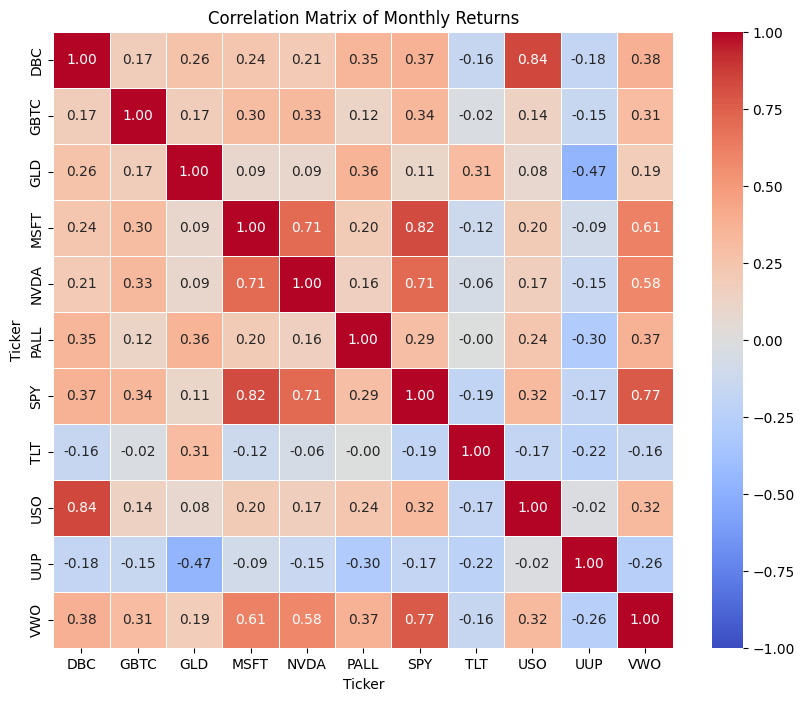

La matrice de corrélation est inversible.
Statut de la résolution : optimal
Risque minimal (variance) : 0.1465241869593192

Poids optimaux par actif :
MSFT    9.055175e-02
NVDA    1.259522e-02
SPY     1.775615e-01
TLT     3.748328e-02
GLD     4.631971e-02
UUP     2.301185e-03
DBC     1.257719e-24
VWO     2.675991e-23
GBTC    4.092071e-24
USO     6.331873e-01
PALL    5.723083e-23
dtype: float64


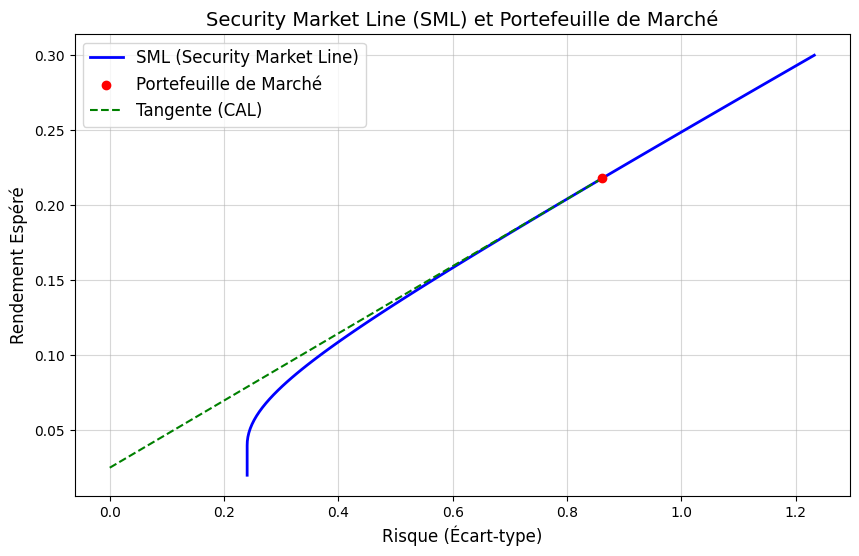

Poids du portefeuille de marché : [ 0.36954672  0.04161716  0.23554546  0.18569755  0.15186143  0.01730753
 -0.29782884 -0.145909   -0.07746744  0.6332268  -0.11359737]
Rendement du portefeuille de marché : 0.21797979797979794
Risque du portefeuille de marché : 0.861689981429221


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

class PortfolioAnalysis:
    def __init__(self, tickers, start_date, end_date, risk_free_rate=0.025):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.risk_free_rate = risk_free_rate
        self.prices = None
        self.returns = None
        self.cov_matrix = None
        self.mu = None  # Expected returns
        self.Sigma = None  # Variance-covariance matrix

    def fetch_data(self):
        """Fetches closing prices for the tickers."""
        self.prices = yf.download(self.tickers, start=self.start_date, end=self.end_date)['Close']
        print(self.prices)

    def calculate_returns(self):
        """Calculates total and annualized returns."""
        total_returns = (self.prices.iloc[-1] / self.prices.iloc[0]) - 1
        self.returns = {
            'total': total_returns * 100,
            'annualized': ((1 + total_returns) ** (1 / 5) - 1) * 100
        }
        print("Rendements totaux sur 5 ans (%):")
        print(self.returns['total'])
        print("\nRendements annualisés (%):")
        print(self.returns['annualized'])

    def calculate_monthly_returns(self):
        """Calculates monthly returns and covariance matrices."""
        monthly_prices = self.prices.resample('M').last()
        monthly_returns = monthly_prices.pct_change()
        self.cov_matrix = monthly_returns.cov() * 12 * 100  # Annualized covariance matrix
        self.mu = monthly_returns.mean() * 12  # Annualized mean returns
        self.Sigma = self.cov_matrix
        print("\nMatrice de variance-covariance annualisée des rendements (en pourcentage) :")
        print(self.cov_matrix)

    def display_correlation_heatmap(self):
        """Displays a heatmap of the correlation matrix."""
        corr_matrix = self.prices.pct_change().corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix of Monthly Returns')
        plt.show()
        det_corr_matrix = np.linalg.det(corr_matrix)
        if det_corr_matrix != 0:
            print("La matrice de corrélation est inversible.")
        else:
            print("La matrice de corrélation n'est pas inversible.")

    def optimize_portfolio(self, target_return=0.15):
        """Solves for the portfolio weights that minimize risk given a target return."""
        n = len(self.tickers)
        weights = cp.Variable(n)
        risk = cp.quad_form(weights, self.Sigma)
        constraints = [
            cp.sum(weights) == 1,
            weights @ self.mu >= target_return,
            weights >= 0,  # No short selling
            weights <= 1 # Interdiction de vendre à découvert
        ]
        problem = cp.Problem(cp.Minimize(risk), constraints)
        problem.solve()
        print("Statut de la résolution :", problem.status)
        print("Risque minimal (variance) :", problem.value)
        optimal_weights = pd.Series(weights.value, index=self.tickers)
        print("\nPoids optimaux par actif :")
        print(optimal_weights)
        return weights.value

    def find_tangency_portfolio(self):
        """Finds the tangency portfolio and plots the SML with CAL."""
        mu_targets = np.linspace(0.02, 0.3, 100)
        risks = []
        max_slope = -np.inf
        tangency_weights = None
        tangency_return = None
        tangency_risk = None
        for target in mu_targets:
            weights = cp.Variable(len(self.mu))
            risk = cp.quad_form(weights, self.Sigma)
            constraints = [
                weights @ self.mu >= target,
                cp.sum(weights) == 1
            ]
            problem = cp.Problem(cp.Minimize(risk), constraints)
            problem.solve()
            portfolio_risk = np.sqrt(problem.value)
            risks.append(portfolio_risk)
            slope = (target - self.risk_free_rate) / portfolio_risk if portfolio_risk > 0 else -np.inf
            if slope > max_slope:
                max_slope = slope
                tangency_weights = weights.value
                tangency_return = target
                tangency_risk = portfolio_risk
        plt.figure(figsize=(10, 6))
        plt.plot(risks, mu_targets, label='SML (Security Market Line)', color='blue', lw=2)
        plt.scatter([tangency_risk], [tangency_return], color='red', label='Portefeuille de Marché', zorder=5)
        plt.plot([0, tangency_risk], [self.risk_free_rate, tangency_return], label='Tangente (CAL)', color='green', linestyle='--')
        plt.xlabel('Risque (Écart-type)', fontsize=12)
        plt.ylabel('Rendement Espéré', fontsize=12)
        plt.title('Security Market Line (SML) et Portefeuille de Marché', fontsize=14)
        plt.grid(alpha=0.5)
        plt.legend(fontsize=12)
        plt.show()
        print("Poids du portefeuille de marché :", tangency_weights)
        print("Rendement du portefeuille de marché :", tangency_return)
        print("Risque du portefeuille de marché :", tangency_risk)

# Usage:
tickers = ['MSFT', 'NVDA', 'SPY', 'TLT', 'GLD', 'UUP', 'DBC', 'VWO', 'GBTC', 'USO', 'PALL']
portfolio_analysis = PortfolioAnalysis(tickers, '2019-01-01', '2024-01-01')
portfolio_analysis.fetch_data() # télécharger les données de prix de clôture des actifs spécifiés sur Yahoo Finance pour la période donnée.
portfolio_analysis.calculate_returns() # calculer les rendements totaux sur la période spécifiée ainsi que les rendements annualisés
portfolio_analysis.calculate_monthly_returns() #calculer les rendements mensuels des prix et produit la matrice de covariance annualisée des rendements
portfolio_analysis.display_correlation_heatmap() # la matrice de corrélation des rendements mensuels
optimal_weights = portfolio_analysis.optimize_portfolio(0.1)  # 10% target return   # résoudre un problème d'optimisation pour trouver les poids des actifs qui minimisent le risque pour un rendement cible donné
portfolio_analysis.find_tangency_portfolio() #rechercher le portefeuille de tangence qui maximise le rapport Sharpe (pente) par rapport au taux sans risque
